# Optimize unit model

In this tutorial we will learn:

![unit.png](./unit.png)

1. Setting up flowsheet and unit model
2. Creating a sensitivity analysis
3. Plotting results
4. Setting up optimization

# 1. Setting up flowsheet and unit model

## 1.1 Importing necessary libraries

In [1]:
from pyomo.environ import (
    Objective,
    ConcreteModel,
    Constraint,
    units,
    value,
)

from idaes.core import FlowsheetBlock
from idaes.core.solvers import get_solver

import idaes.logger as idaeslog

from prommis.precipitate.precipitate_reactions import OxalatePrecipitationReactions
from prommis.precipitate.precipitator import (
    OxalatePrecipitator,
    OxalatePrecipitatorInitializer,
)
from prommis.precipitate.precipitate_liquid_properties import AqueousParameter
from prommis.precipitate.precipitate_solids_properties import PrecipitateParameters

import numpy as np
import matplotlib.pyplot as plt

## 1.2 Create the flowsheet and add the unit models

In [2]:
_log = idaeslog.getLogger(__name__)

# Create m (model)
m = ConcreteModel()

# Add flowsheet
m.fs = FlowsheetBlock(dynamic=False)

# Call solid and liquid properties
m.fs.properties_aq = AqueousParameter()
m.fs.properties_solid = PrecipitateParameters()

# Call reactions
m.fs.prec_rxns = OxalatePrecipitationReactions()

# Add unit model to flowsheet
m.fs.precipitator = OxalatePrecipitator(
    number_of_tanks=1,
    liquid_phase={
        "property_package": m.fs.properties_aq,
        "has_energy_balance": False,
        "has_pressure_balance": False,
    },
    solid_phase={
        "property_package": m.fs.properties_solid,
        "has_energy_balance": False,
        "has_pressure_balance": False,
    },
    reaction_package=m.fs.prec_rxns,
)

## 1.3 Add operating conditions

In [3]:
Temp_room = 303 * units.K
P_atm = 101235 * units.Pa
eps=1e-8

# Assuming pH is 1.5, oxalic acid molarity is 0.0316M -> 2844.95 mgH2C2O4/L
# Since pH of 1.5, cannot solve, assume a pH of 1.16 -> 8000 mgH2C2O4/L
m.fs.precipitator.mscontactor.liquid_inlet.flow_vol.fix(50)
m.fs.precipitator.mscontactor.liquid_inlet.pressure.fix(P_atm)
m.fs.precipitator.mscontactor.liquid_inlet.temperature.fix(Temp_room)
m.fs.precipitator.mscontactor.liquid_inlet.conc_mass_comp[0, "H2O"].fix(1000000)
m.fs.precipitator.mscontactor.liquid_inlet.conc_mass_comp[0, "H"].fix(eps)
m.fs.precipitator.mscontactor.liquid_inlet.conc_mass_comp[0, "SO4"].fix(eps)
m.fs.precipitator.mscontactor.liquid_inlet.conc_mass_comp[0, "HSO4"].fix(eps)
m.fs.precipitator.mscontactor.liquid_inlet.conc_mass_comp[0, "H2C2O4"].fix(8000)
m.fs.precipitator.mscontactor.liquid_inlet.conc_mass_comp[0, "Cl"].fix(100)
m.fs.precipitator.mscontactor.liquid_inlet.conc_mass_comp[0, "Al"].fix(100)
m.fs.precipitator.mscontactor.liquid_inlet.conc_mass_comp[0, "Ca"].fix(100)
m.fs.precipitator.mscontactor.liquid_inlet.conc_mass_comp[0, "Fe"].fix(100)
m.fs.precipitator.mscontactor.liquid_inlet.conc_mass_comp[0, "Sc"].fix(100)
m.fs.precipitator.mscontactor.liquid_inlet.conc_mass_comp[0, "Y"].fix(100)
m.fs.precipitator.mscontactor.liquid_inlet.conc_mass_comp[0, "La"].fix(100)
m.fs.precipitator.mscontactor.liquid_inlet.conc_mass_comp[0, "Ce"].fix(100)
m.fs.precipitator.mscontactor.liquid_inlet.conc_mass_comp[0, "Pr"].fix(100)
m.fs.precipitator.mscontactor.liquid_inlet.conc_mass_comp[0, "Nd"].fix(100)
m.fs.precipitator.mscontactor.liquid_inlet.conc_mass_comp[0, "Sm"].fix(100)
m.fs.precipitator.mscontactor.liquid_inlet.conc_mass_comp[0, "Gd"].fix(100)
m.fs.precipitator.mscontactor.liquid_inlet.conc_mass_comp[0, "Dy"].fix(100)

m.fs.precipitator.precipitate_outlet.temperature.fix(Temp_room)
m.fs.precipitator.hydraulic_retention_time[0].fix(2)

Call ipopt as solver

In [4]:
solver = get_solver("ipopt_v2")

Initialize the unit model

In [5]:
initializer_precip = OxalatePrecipitatorInitializer()

initializer_precip.initialize(m.fs.precipitator)

2025-08-24 21:43:20 [INFO] idaes.init.fs.precipitator.mscontactor: Stream Initialization Completed.
2025-08-24 21:43:21 [INFO] idaes.init.fs.precipitator.mscontactor: Initialization Completed, optimal - <undefined>
component keys that are not exported as part of the NL file.  Skipping.
Ipopt 3.13.2: linear_solver=ma57
max_iter=200
nlp_scaling_method=gradient-based
tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version

<InitializationStatus.Ok: 1>

## 1.5 Solve model

In [6]:
 results = solver.solve(m, tee=False)

component keys that are not exported as part of the NL file.  Skipping.


## 2 sensitivity analysis over acid dosage

In [7]:
# Create arrays to store oxalate outlet
Al_oxalate = []
Ca_oxalate = []
Fe_oxalate = []
Sc_oxalate = []
Y_oxalate = []
La_oxalate = []
Ce_oxalate = []
Pr_oxalate = []
Nd_oxalate = []
Sm_oxalate = []
Gd_oxalate = []
Dy_oxalate = []

# Create arrays to store REE recovery
Al_recovery = []
Ca_recovery = []
Fe_recovery = []
Sc_recovery = []
Y_recovery = []
La_recovery = []
Ce_recovery = []
Pr_recovery = []
Nd_recovery = []
Sm_recovery = []
Gd_recovery = []
Dy_recovery = []

# Generate array for oxalic acid dosage
oxalic_acid = np.linspace(4000, 10000, 10)

for i in range(len(oxalic_acid)):

    m.fs.precipitator.mscontactor.liquid_inlet.conc_mass_comp[0, "H2C2O4"].fix(oxalic_acid[i])
 
    results = solver.solve(m, tee=False)
    
    Al_oxalate.append(value(m.fs.precipitator.precipitate_outlet.flow_mol_comp[0, "Al2(C2O4)3(s)"]))
    Ca_oxalate.append(value(m.fs.precipitator.precipitate_outlet.flow_mol_comp[0, "Ca(C2O4)(s)"]))
    Fe_oxalate.append(value(m.fs.precipitator.precipitate_outlet.flow_mol_comp[0, "Fe2(C2O4)3(s)"]))
    Sc_oxalate.append(value(m.fs.precipitator.precipitate_outlet.flow_mol_comp[0, "Sc2(C2O4)3(s)"]))
    Y_oxalate.append(value(m.fs.precipitator.precipitate_outlet.flow_mol_comp[0, "Y2(C2O4)3(s)"]))
    La_oxalate.append(value(m.fs.precipitator.precipitate_outlet.flow_mol_comp[0, "La2(C2O4)3(s)"]))
    Ce_oxalate.append(value(m.fs.precipitator.precipitate_outlet.flow_mol_comp[0, "Ce2(C2O4)3(s)"]))
    Pr_oxalate.append(value(m.fs.precipitator.precipitate_outlet.flow_mol_comp[0, "Pr2(C2O4)3(s)"]))
    Nd_oxalate.append(value(m.fs.precipitator.precipitate_outlet.flow_mol_comp[0, "Nd2(C2O4)3(s)"]))
    Sm_oxalate.append(value(m.fs.precipitator.precipitate_outlet.flow_mol_comp[0, "Sm2(C2O4)3(s)"]))
    Gd_oxalate.append(value(m.fs.precipitator.precipitate_outlet.flow_mol_comp[0, "Gd2(C2O4)3(s)"]))
    Dy_oxalate.append(value(m.fs.precipitator.precipitate_outlet.flow_mol_comp[0, "Dy2(C2O4)3(s)"]))

    # Calculate and store recovery
    Al_recovery.append(value(m.fs.precipitator.precipitate_outlet.flow_mol_comp[0, "Al2(C2O4)3(s)"]/
                             (2*m.fs.precipitator.mscontactor.liquid_inlet_state[0.0].flow_mol_comp["Al"])))
    Ca_recovery.append(value(m.fs.precipitator.precipitate_outlet.flow_mol_comp[0, "Ca(C2O4)(s)"]*2/
                             (m.fs.precipitator.mscontactor.liquid_inlet_state[0.0].flow_mol_comp["Ca"])))
    Fe_recovery.append(value(m.fs.precipitator.precipitate_outlet.flow_mol_comp[0, "Fe2(C2O4)3(s)"]*2/
                             (m.fs.precipitator.mscontactor.liquid_inlet_state[0.0].flow_mol_comp["Fe"])))
    Sc_recovery.append(value(m.fs.precipitator.precipitate_outlet.flow_mol_comp[0, "Sc2(C2O4)3(s)"]*2/
                             (m.fs.precipitator.mscontactor.liquid_inlet_state[0.0].flow_mol_comp["Sc"])))
    Y_recovery.append(value(m.fs.precipitator.precipitate_outlet.flow_mol_comp[0, "Y2(C2O4)3(s)"]*2/
                             (m.fs.precipitator.mscontactor.liquid_inlet_state[0.0].flow_mol_comp["Y"])))
    La_recovery.append(value(m.fs.precipitator.precipitate_outlet.flow_mol_comp[0, "La2(C2O4)3(s)"]*2/
                             (m.fs.precipitator.mscontactor.liquid_inlet_state[0.0].flow_mol_comp["La"])))
    Ce_recovery.append(value(m.fs.precipitator.precipitate_outlet.flow_mol_comp[0, "Ce2(C2O4)3(s)"]*2/
                             (m.fs.precipitator.mscontactor.liquid_inlet_state[0.0].flow_mol_comp["Ce"])))
    Pr_recovery.append(value(m.fs.precipitator.precipitate_outlet.flow_mol_comp[0, "Pr2(C2O4)3(s)"]*2/
                             (m.fs.precipitator.mscontactor.liquid_inlet_state[0.0].flow_mol_comp["Pr"])))
    Nd_recovery.append(value(m.fs.precipitator.precipitate_outlet.flow_mol_comp[0, "Nd2(C2O4)3(s)"]*2/
                             (m.fs.precipitator.mscontactor.liquid_inlet_state[0.0].flow_mol_comp["Nd"])))
    Sm_recovery.append(value(m.fs.precipitator.precipitate_outlet.flow_mol_comp[0, "Sm2(C2O4)3(s)"]*2/
                             (m.fs.precipitator.mscontactor.liquid_inlet_state[0.0].flow_mol_comp["Sm"])))
    Gd_recovery.append(value(m.fs.precipitator.precipitate_outlet.flow_mol_comp[0, "Gd2(C2O4)3(s)"]*2/
                             (m.fs.precipitator.mscontactor.liquid_inlet_state[0.0].flow_mol_comp["Gd"])))
    Dy_recovery.append(value(m.fs.precipitator.precipitate_outlet.flow_mol_comp[0, "Dy2(C2O4)3(s)"]*2/
                             (m.fs.precipitator.mscontactor.liquid_inlet_state[0.0].flow_mol_comp["Dy"])))

component keys that are not exported as part of the NL file.  Skipping.
component keys that are not exported as part of the NL file.  Skipping.
component keys that are not exported as part of the NL file.  Skipping.
component keys that are not exported as part of the NL file.  Skipping.
component keys that are not exported as part of the NL file.  Skipping.
component keys that are not exported as part of the NL file.  Skipping.
component keys that are not exported as part of the NL file.  Skipping.
component keys that are not exported as part of the NL file.  Skipping.
component keys that are not exported as part of the NL file.  Skipping.
component keys that are not exported as part of the NL file.  Skipping.


## 3 Plot results

<function matplotlib.pyplot.show(close=None, block=None)>

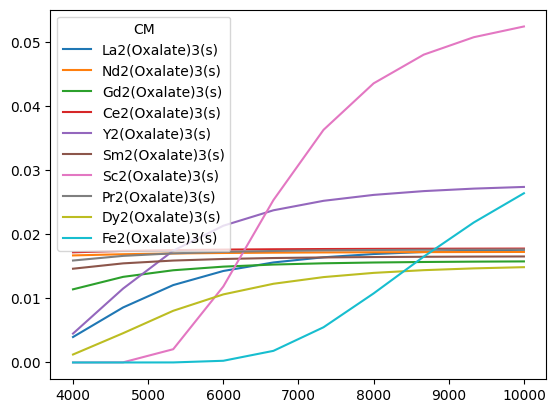

In [8]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.plot(oxalic_acid,La_oxalate,label="La2(Oxalate)3(s)")
ax.plot(oxalic_acid,Nd_oxalate,label="Nd2(Oxalate)3(s)")
ax.plot(oxalic_acid,Gd_oxalate,label="Gd2(Oxalate)3(s)")
ax.plot(oxalic_acid,Ce_oxalate,label="Ce2(Oxalate)3(s)")
ax.plot(oxalic_acid,Y_oxalate,label="Y2(Oxalate)3(s)")
ax.plot(oxalic_acid,Sm_oxalate,label="Sm2(Oxalate)3(s)")
ax.plot(oxalic_acid,Sc_oxalate,label="Sc2(Oxalate)3(s)")
ax.plot(oxalic_acid,Pr_oxalate,label="Pr2(Oxalate)3(s)")
ax.plot(oxalic_acid,Dy_oxalate,label="Dy2(Oxalate)3(s)")
ax.plot(oxalic_acid,Fe_oxalate,label="Fe2(Oxalate)3(s)")

ax.legend(title='CM')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

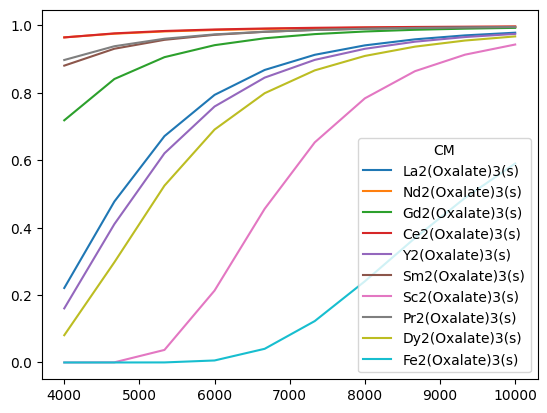

In [9]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.plot(oxalic_acid,La_recovery,label="La2(Oxalate)3(s)")
ax.plot(oxalic_acid,Nd_recovery,label="Nd2(Oxalate)3(s)")
ax.plot(oxalic_acid,Gd_recovery,label="Gd2(Oxalate)3(s)")
ax.plot(oxalic_acid,Ce_recovery,label="Ce2(Oxalate)3(s)")
ax.plot(oxalic_acid,Y_recovery,label="Y2(Oxalate)3(s)")
ax.plot(oxalic_acid,Sm_recovery,label="Sm2(Oxalate)3(s)")
ax.plot(oxalic_acid,Sc_recovery,label="Sc2(Oxalate)3(s)")
ax.plot(oxalic_acid,Pr_recovery,label="Pr2(Oxalate)3(s)")
ax.plot(oxalic_acid,Dy_recovery,label="Dy2(Oxalate)3(s)")
ax.plot(oxalic_acid,Fe_recovery,label="Fe2(Oxalate)3(s)")

ax.legend(title='CM')
plt.show

# 4 Optimization

## 4.1 unfix variables

In [10]:
m.fs.precipitator.mscontactor.liquid_inlet.conc_mass_comp[0, "H2C2O4"].fix(8000)
m.fs.precipitator.mscontactor.liquid_inlet.conc_mass_comp[0, "H2C2O4"].unfix()

## 4.2 Add objective function and constraints

In [11]:
m.fs.objective = Objective(expr = m.fs.precipitator.mscontactor.liquid_inlet.conc_mass_comp[0, "H2C2O4"])

m.fs.dy_conversion = Constraint(expr=m.fs.precipitator.precipitate_outlet.flow_mol_comp[0, "Dy2(C2O4)3(s)"]*2/
                             (m.fs.precipitator.mscontactor.liquid_inlet_state[0.0].flow_mol_comp["Dy"]) >= 0.90)

m.fs.product_purity = Constraint(expr=m.fs.precipitator.precipitate_outlet.flow_mol_comp[0, "Fe2(C2O4)3(s)"] <= 0.01)

## 4.3 Solve the optimization problem

In [12]:
# Call solver
solver_options = {"max_iter": 500}    

results = solver.solve(m, solver_options=solver_options, tee=True)

component keys that are not exported as part of the NL file.  Skipping.
Ipopt 3.13.2: linear_solver=ma57
max_iter=500
nlp_scaling_method=gradient-based
tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT mu

## 4.4 Print result

In [13]:
print("Oxalic acid dosage = ", value(m.fs.precipitator.mscontactor.liquid_inlet.conc_mass_comp[0, "H2C2O4"]), "mol/L")

Oxalic acid dosage =  7821.380760431412 mol/L
